In [1]:
import train as train
import generate
import eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
BASE_DIR = "./experiments/sanity_check_mcmc"
PROFILE = "sin-1x-mcmc"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-1x-10k ======


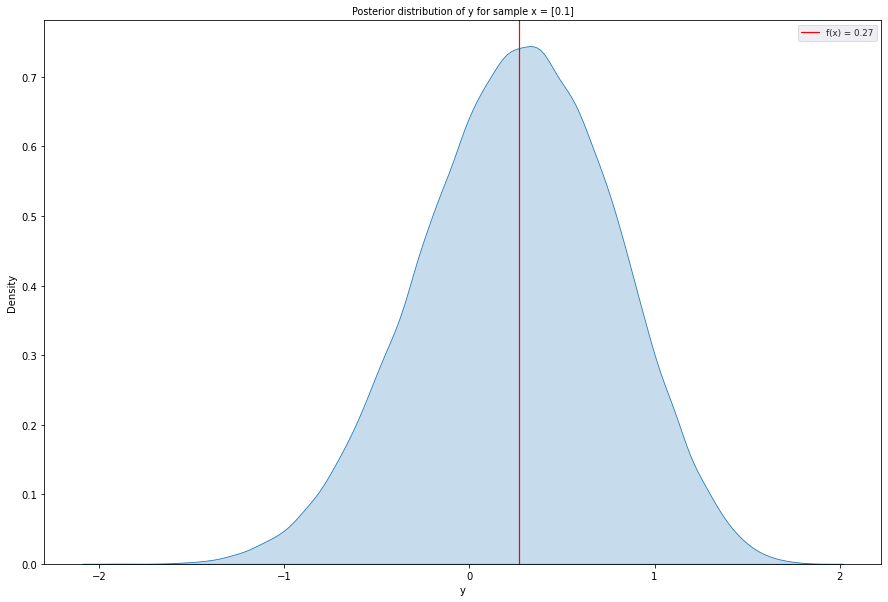

In [4]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [5]:
_, _, (x_test, y_test), (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_train=False, load_val=False)

In [6]:
x_test[0], y_test[0]

(tensor([-0.5392]), tensor(-1.0654))

<AxesSubplot:>

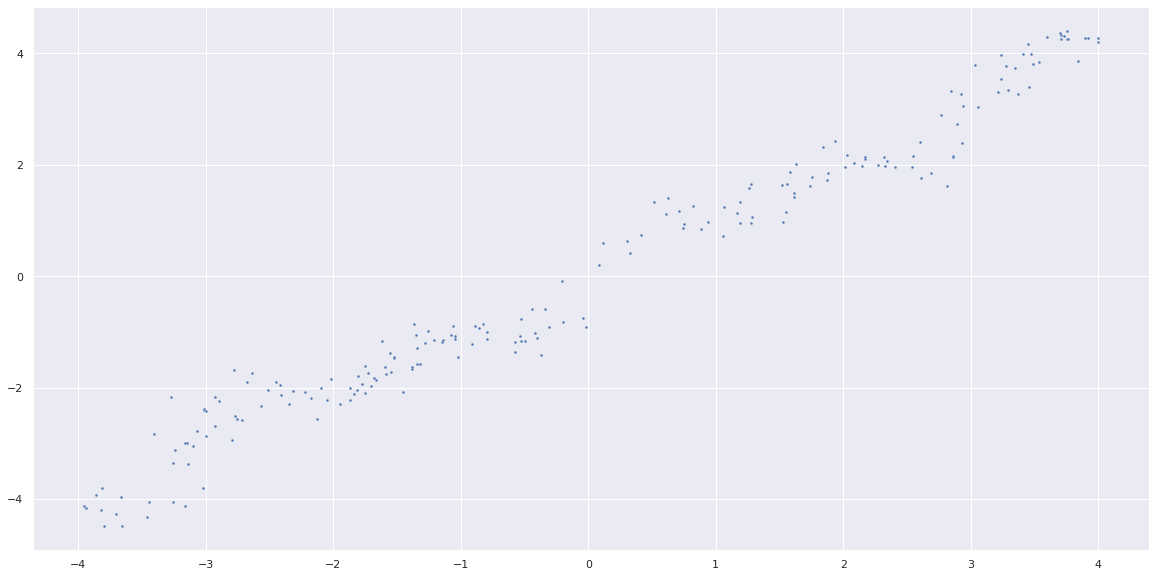

In [7]:
sns.set(rc = {'figure.figsize':(20,10)})
sns.scatterplot(x=x_test.flatten(), y=y_test, s=8)

In [8]:
if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    infer_model = train.train(config, f"{BASE_DIR}")

Using device: cpu
===== Training profile sin-1x =====


Sample: 100%|██████████| 150/150 [07:18,  2.92s/it, step size=9.61e-04, acc. prob=0.695]


[0:07:19][mcmc finished] rmse: 0.3431
Training finished in 0:07:18.530690 seconds
Saved model and samples to ./experiments/sanity_check_mcmc/models/sin-1x


In [9]:
inference_model = eval.load_model(BASE_DIR, config)

Loaded model and samples from ./experiments/sanity_check_mcmc/models/sin-1x


In [10]:
inference_model.mcmc.diagnostics()

{'fc.0.0.linear.bias': OrderedDict([('n_eff',
               tensor([ 7.4157, 10.1608,  5.4958,  4.7681,  7.8900,  4.8187,  5.0393,  4.8147,
                        2.8920,  7.7944,  2.5261,  3.7191,  2.7497,  8.2347,  5.7484,  7.3387,
                        3.7462, 14.6328,  4.3144,  4.7570,  4.0317,  4.7853,  3.1439,  4.0580,
                        5.7815,  5.5119,  4.7939,  4.5310,  3.1292,  5.6792,  5.6334,  3.2107])),
              ('r_hat',
               tensor([1.2393, 1.0072, 1.0207, 1.0963, 1.3970, 1.3621, 1.3346, 1.0149, 2.0952,
                       1.1302, 3.2474, 1.7948, 2.1118, 1.1823, 1.1366, 1.3819, 1.6118, 1.0286,
                       1.8818, 1.5063, 1.7996, 1.0340, 1.8748, 1.9710, 1.4844, 1.1470, 1.2261,
                       1.1606, 3.7443, 1.2810, 1.0833, 2.2265]))]),
 'fc.0.0.linear.weight': OrderedDict([('n_eff',
               tensor([[ 3.3943],
                       [ 4.4013],
                       [ 8.0561],
                       [ 5.2056],
          

In [11]:
predictive = inference_model.get_predictive(num_predictions=500)
samples = predictive(x_test)
samples.keys()

dict_keys(['obs', '_RETURN'])

In [12]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

pred_summary = summary(samples)

In [13]:
y = pred_summary["obs"]
mu = pred_summary["_RETURN"]
predictions = pd.DataFrame({
    "x": x_test.flatten(),
    "mu": mu["mean"].flatten(),
    "mu_5": mu["5%"].flatten(),
    "mu_95": mu["95%"].flatten(),
    "y_mean": y["mean"].flatten(),
    "y_5": y["5%"].flatten(),
    "y_95": y["95%"].flatten(),
    "true_y": y_test.flatten()
})

In [14]:
predictions.head()

,x,mu,mu_5,mu_95,y_mean,y_5,y_95,true_y
0,-0.539227,-0.995094,-1.054981,-0.923496,-0.997697,-1.561553,-0.466595,-1.065415
1,1.278432,0.691541,-2.379590,2.154084,0.708377,-2.459651,2.363966,1.649818
2,-3.244102,-0.548231,-12.457317,8.077745,-0.565094,-12.503883,8.167318,-3.113240
3,-1.549847,-0.956294,-4.106480,0.958003,-0.955069,-3.678278,1.085282,-1.719863
4,2.688141,-2.708304,-30.714397,12.106217,-2.714869,-30.896742,11.528467,1.855075


In [15]:
sorted_pred = predictions.sort_values(by='x')

def plot_predictions(summary):
    sns.set(rc = {'figure.figsize':(25,12)})
    fig, ax = plt.subplots()

    ax.set_title("Posterior predictive distribution with 95% CI")
    sns.lineplot(x=summary['x'], y=summary['mu'], ax=ax, color='red')
    ax.fill_between(x=summary['x'], y1=summary['mu_5'], y2=summary['mu_95'], alpha=0.3, color='green')
    sns.scatterplot(x=summary['x'], y=summary['true_y'], ax=ax, alpha=0.7, size=0.5, legend=False)
    
    sns.set(rc = {'figure.figsize':(25,12)})
    fig, ax = plt.subplots()

    ax.set_title("Posterior predictive distribution with 95% CI")
    sns.lineplot(x=summary['x'], y=summary['y_mean'], ax=ax, color='red')
    ax.fill_between(x=summary['x'], y1=summary['y_5'], y2=summary['y_95'], alpha=0.3, color='green')
    sns.scatterplot(x=summary['x'], y=summary['true_y'], ax=ax, alpha=0.7, size=0.5, legend=False)

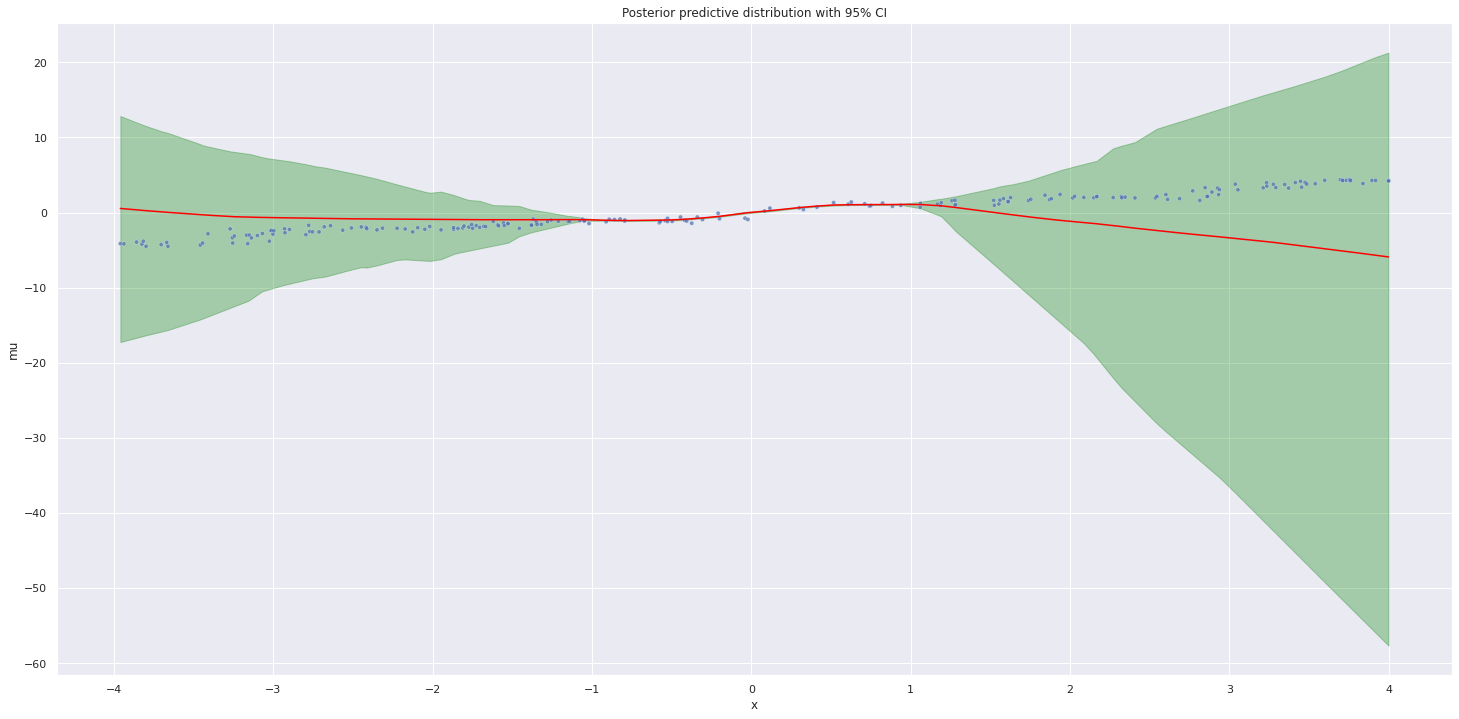

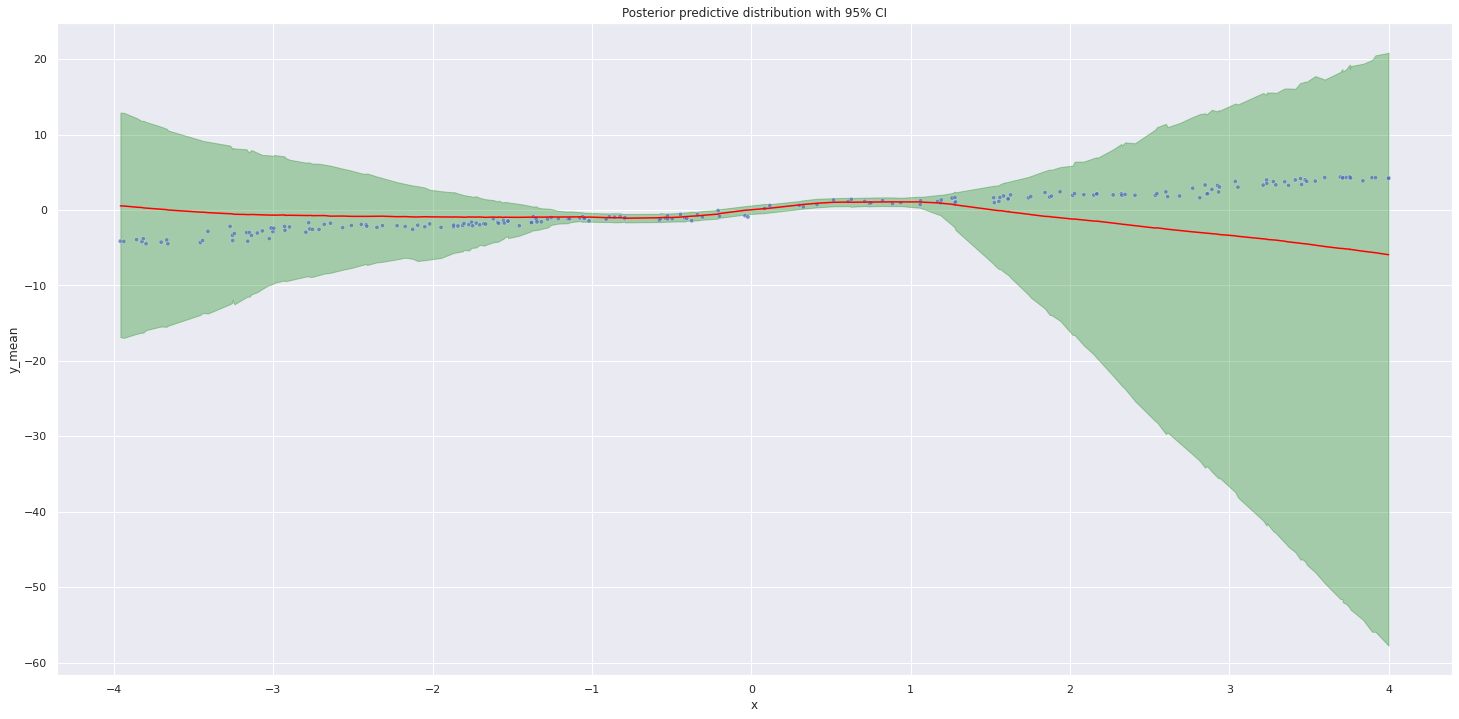

In [16]:
plot_predictions(sorted_pred)

Loaded model and samples from ./experiments/sanity_check_mcmc/models/sin-1x
using device: cpu
====== evaluating profile sin-1x ======
Eval done in 0:01:16.833514


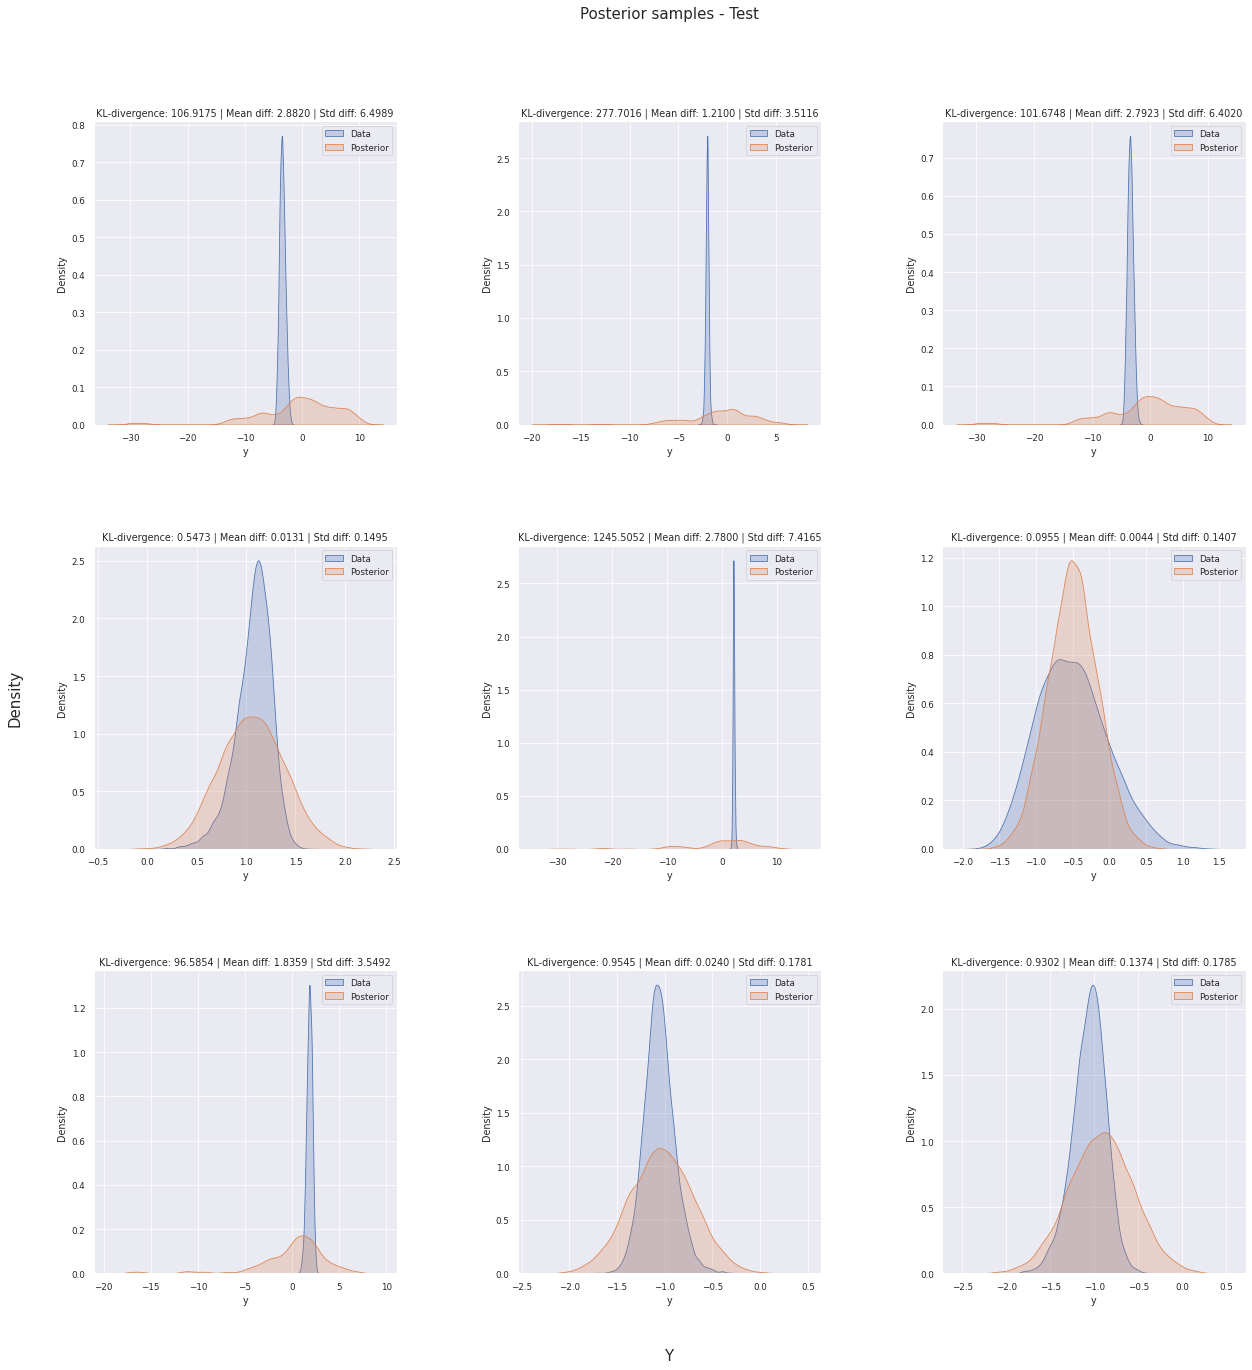

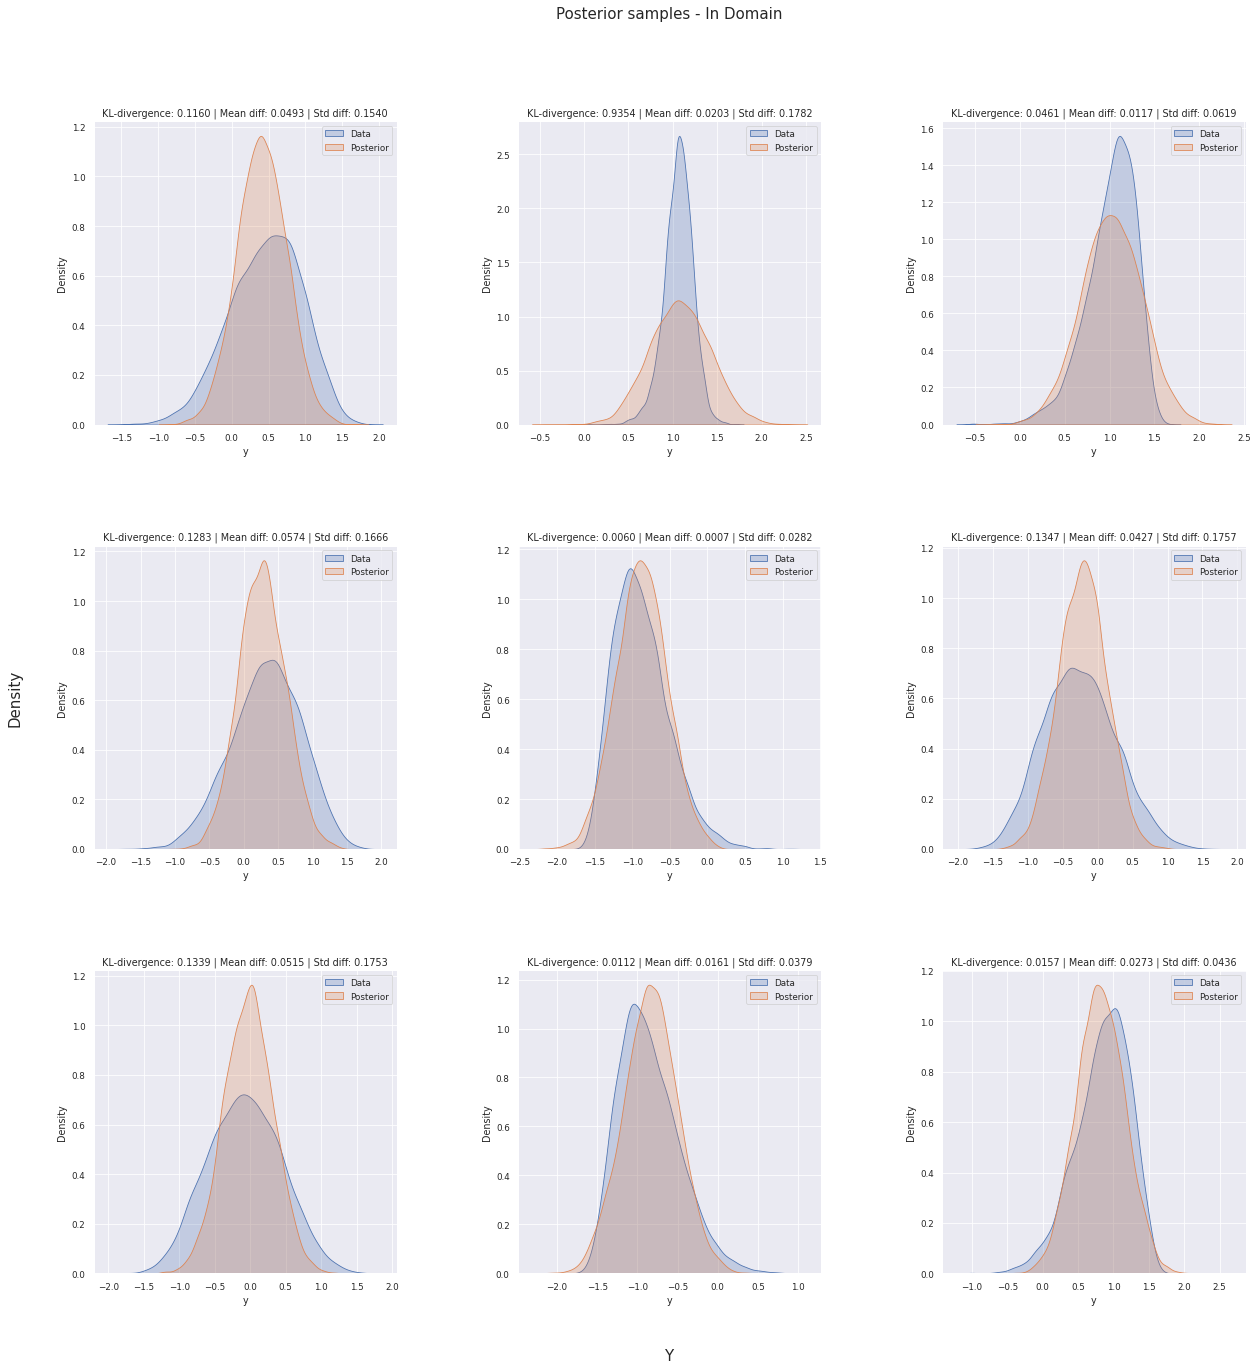

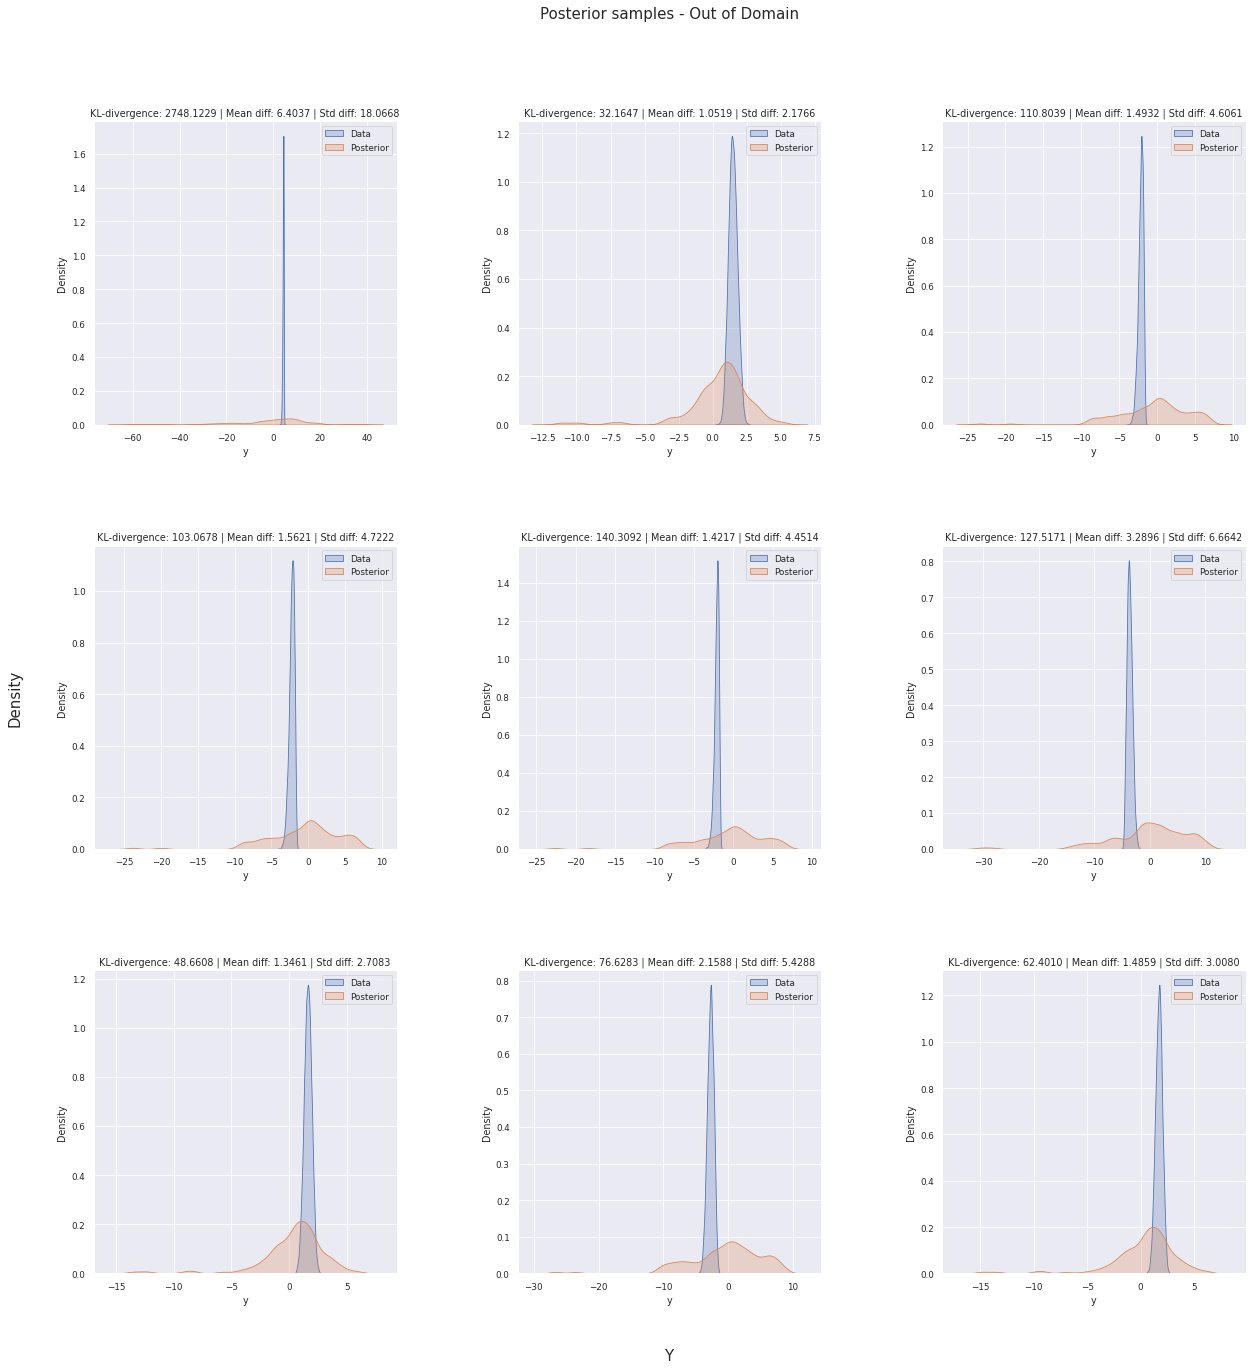

In [17]:
if True:
            if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")

            eval.eval(config, dataset_config, f"{BASE_DIR}")